In [ ]:
pip show tensorflow

Name: tensorflow
Version: 2.19.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.12/dist-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, requests, setuptools, six, tensorboard, termcolor, typing-extensions, wrapt
Required-by: dopamine_rl, tensorflow-text, tensorflow_decision_forests, tf_keras


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
from google.colab import files
uploaded = files.upload()

file_paths = [
    'amazon_cells_labelled.txt',
    'imdb_labelled.txt',
    'yelp_labelled.txt']
dfs = []
for path in file_paths:
    df_temp = pd.read_csv(path, sep='\t', header=None, names=['sentence', 'label'])
    print(f"Loaded {path}: {len(df_temp)} rows")
    dfs.append(df_temp)
df = pd.concat(dfs, ignore_index=True)
print("Final concatenated shape:", df.shape)

Saving amazon_cells_labelled.txt to amazon_cells_labelled (2).txt
Saving yelp_labelled.txt to yelp_labelled (2).txt
Saving imdb_labelled.txt to imdb_labelled (2).txt
Loaded amazon_cells_labelled.txt: 1000 rows
Loaded imdb_labelled.txt: 748 rows
Loaded yelp_labelled.txt: 1000 rows
Final concatenated shape: (2748, 2)


In [ ]:
df.isnull()

,sentence,label
0,False,False
1,False,False
2,False,False
3,False,False
4,False,False
...,...,...
2743,False,False
2744,False,False
2745,False,False
2746,False,False


In [ ]:
sentences = df['sentence'].astype(str)
emoji_pattern = re.compile(
    "[\U0001F600-\U0001F64F"
    "\U0001F300-\U0001F5FF"
    "\U0001F680-\U0001F6FF"
    "\U0001F1E0-\U0001F1FF]"
    "|[^\x00-\x7F]+",
    flags=re.UNICODE)
problematic_count = sentences.apply(lambda x: bool(emoji_pattern.search(x))).sum()

print("Reviews containing emojis or non-English characters:", problematic_count)

Reviews containing emojis or non-English characters: 17


In [ ]:
tokenizer_full = Tokenizer()
tokenizer_full.fit_on_texts(sentences)

vocab_size = len(tokenizer_full.word_index)

print("Total unique words in dataset:", vocab_size)

Total unique words in dataset: 5271


In [ ]:
sorted_vocab = sorted(tokenizer_full.word_counts.items(), key=lambda x: x[1], reverse=True)
sorted_vocab[:20]

[('the', 1952),
 ('and', 1138),
 ('i', 897),
 ('a', 889),
 ('is', 753),
 ('it', 674),
 ('to', 670),
 ('this', 643),
 ('of', 624),
 ('was', 570),
 ('in', 400),
 ('for', 336),
 ('not', 306),
 ('that', 304),
 ('with', 274),
 ('my', 254),
 ('very', 245),
 ('good', 230),
 ('on', 221),
 ('great', 210)]

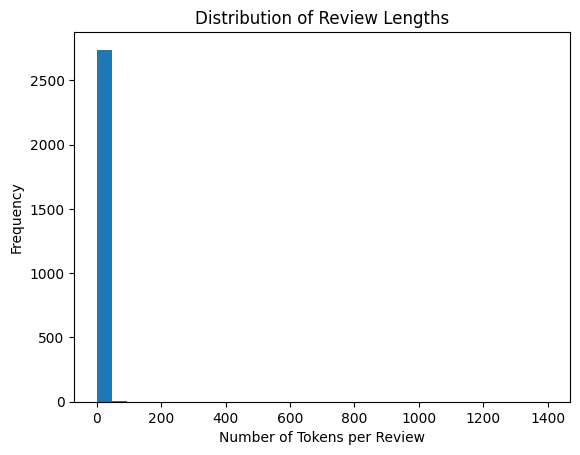

In [ ]:
tokenizer_temp = Tokenizer()
tokenizer_temp.fit_on_texts(sentences)
sequences = tokenizer_temp.texts_to_sequences(sentences)
sequence_lengths = [len(seq) for seq in sequences]
pd.Series(sequence_lengths).describe()
plt.hist(sequence_lengths, bins=30)
plt.xlabel("Number of Tokens per Review")
plt.ylabel("Frequency")
plt.title("Distribution of Review Lengths")
plt.show()

In [ ]:
print("90th percentile length:", np.percentile(sequence_lengths, 90))
print("95th percentile length:", np.percentile(sequence_lengths, 95))

90th percentile length: 22.0
95th percentile length: 26.0


In [ ]:
df.dropna()

,sentence,label
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1
...,...,...
2743,I think food should have flavor and texture an...,0
2744,Appetite instantly gone.,0
2745,Overall I was not impressed and would not go b...,0
2746,"The whole experience was underwhelming, and I ...",0


In [ ]:
df['sentence'] = df['sentence'].str.lower()

In [ ]:
df['sentence'] = df['sentence'].apply(lambda x: re.sub(r'[^\w\s]', '', x))

In [ ]:
sentences = df['sentence'].values
tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)

In [ ]:
max_length = 30
padded_sequences = pad_sequences(
    sequences,
    maxlen=max_length,
    padding='post',
    truncating='post')

In [ ]:
padded_sequences[0]

array([  28,   50,    6,   60,  119,   13,   74,    7,  368,    8,   12,
         68,   12,    2,  184,  639,    4,   78,   63,    5, 2210,    0,
          0,    0,    0,    0,    0,    0,    0,    0], dtype=int32)

In [ ]:
labels = df['label'].values

In [ ]:
prepared_df = pd.DataFrame({
    "cleaned_review": df["sentence"],
    "padded_sequence": padded_sequences.tolist(),
    "sentiment": labels})
prepared_df.to_csv("prepared_sentiment_dataset.csv", index=False)

In [ ]:
from google.colab import files
files.download("prepared_sentiment_dataset.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(
    padded_sequences,
    labels,
    test_size=0.2,
    random_state=42,
    stratify=labels)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=0.5,
    random_state=42,
    stratify=y_temp)

In [ ]:
embedding_results = {}

for size in [50, 100, 200]:
    print(f"\nTesting embedding dimension: {size}")

    model_temp = Sequential([
        Embedding(input_dim=5000, output_dim=size, input_length=30),
        LSTM(64),
        Dropout(0.5),
        Dense(1, activation='sigmoid')])

    model_temp.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    history_temp = model_temp.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=5,
        batch_size=32,
        verbose=0)

    val_acc = max(history_temp.history['val_accuracy'])
    embedding_results[size] = val_acc
    print(f"Best validation accuracy with embedding {size}: {val_acc:.4f}")

print("\nResults:", embedding_results)


Testing embedding dimension: 50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Best validation accuracy with embedding 50: 0.8000

Testing embedding dimension: 100
Best validation accuracy with embedding 100: 0.8073

Testing embedding dimension: 200
Best validation accuracy with embedding 200: 0.7782

Results: {50: 0.800000011920929, 100: 0.807272732257843, 200: 0.778181791305542}


In [ ]:
model = Sequential([
    Embedding(
        input_dim=5000,
        output_dim=200,
        input_length=30),
    LSTM(64),
    Dropout(0.5),
    Dense(1, activation='sigmoid')])

In [ ]:
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy'])

model.build(input_shape=(None, max_length))
model.summary()

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_16 (Embedding)        │ (None, 30, 200)        │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_16 (LSTM)                  │ (None, 64)             │        67,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,067,905 (4.07 MB)

 Trainable params: 1,067,905 (4.07 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True)
history = model.fit(
    X_train,
    y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stop],
    verbose=1)

Epoch 1/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - accuracy: 0.5070 - loss: 0.6952 - val_accuracy: 0.4945 - val_loss: 0.6974
Epoch 2/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.5290 - loss: 0.6874 - val_accuracy: 0.6945 - val_loss: 0.6097
Epoch 3/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.8125 - loss: 0.4377 - val_accuracy: 0.7818 - val_loss: 0.5032
Epoch 4/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - accuracy: 0.9291 - loss: 0.2151 - val_accuracy: 0.8182 - val_loss: 0.4686
Epoch 5/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.9553 - loss: 0.1671 - val_accuracy: 0.7891 - val_loss: 0.4894
Epoch 6/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.9734 - loss: 0.1051 - val_accuracy: 0.7782 - val_loss: 0.6802
Epoch 7/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.9750 - loss: 0.0783 - val_accuracy: 0.7491 - val_loss: 1.0167


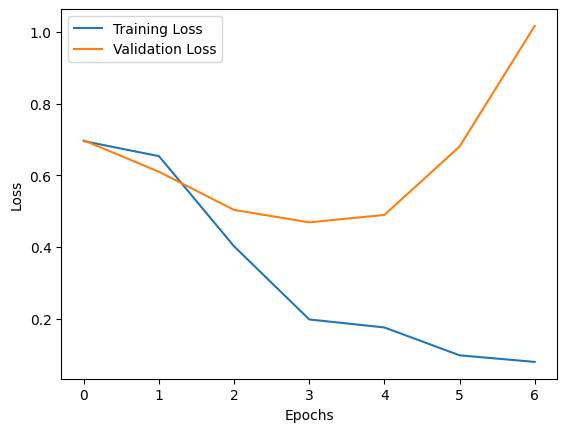

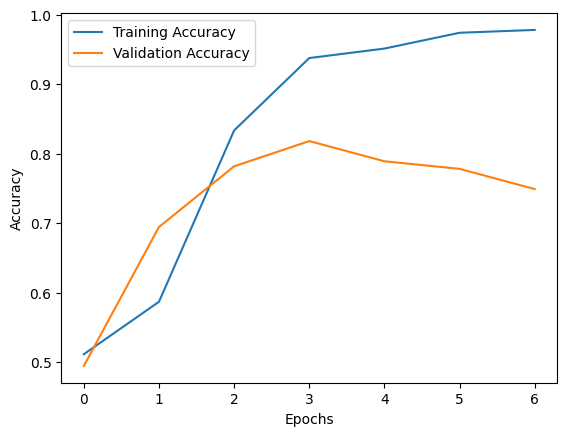

In [ ]:
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.figure()
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Loss: 0.4683
Test Accuracy: 0.8255


In [ ]:
model.save("sentiment_lstm_model.keras")